# Visualization

Professional geospatial visualization and cartography is usually carried in dedicated software packages like Adobe Illustrator or ArcGIS. Most maps produced using programming tend to be simplistic and not particularly inspiring. But does this always have to be the case? There are a few specialists who have been able to produce visualling appealing maps and geovisualizations in Python. In this demo, we will demonstrate how. 

## Topographic maps

We will use **Global Multi-resolution Terrain Elevation Data (GMTED2010)** which was produced by the USGS and the National Geospatial-Intelligence Agency (NGA). The data has a spatial resolution of 7.5 arc-seconds and can be downloaded from the [Earth Explorer](https://earthexplorer.usgs.gov/). 

### Read elevation data

The first thing we do is open and read the data using `rasterio`. Remember that `open` methods produces a rasterio **dataset object**, which contains not only the elevation data but also information about the projection and extent of the image. The `read` method reads the data in the dataset object into a **2D `numpy` array**.

In [3]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

file = rasterio.open('data/30n150w_20101117_gmted_mea075.tif')
dataset = file.read()
print(dataset.shape)

(1, 9600, 14400)


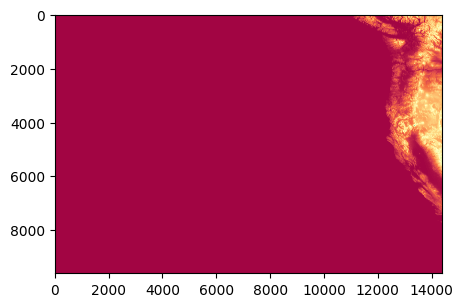

In [66]:
# Plot data
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(dataset[0,:,:], cmap='Spectral')
plt.show()

### Clip to study region

There is a lot of ocean in this plot because geospatial data is often tiled and usually never quite aligns with our study area. Luckily, `rasterio` has a useful method to clip rasters based on a georeferenced shape, e.g. a polygon. In this case we can use an polygon of Oregon which can be downloaded from the [Natural Earth database](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/) to clip the raster using the `rasterio.mask.mask` function. 

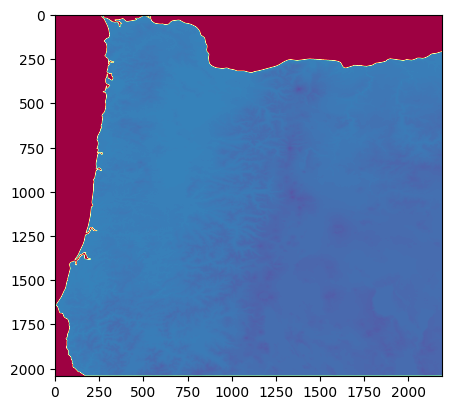

In [65]:
import geopandas as gpd
from shapely.geometry import mapping
from rasterio import mask as msk

# Read Oregon shapefile
oregon_poly = gpd.read_file('data/oregon.shp')

# Clip raster
clipped_array, clipped_transform = msk.mask(file, [mapping(oregon_poly.iloc[0].geometry)], crop=True)

# Plot
plt.figure(figsize=(5,5))
plt.imshow(clipped_array[0], cmap='Spectral')
plt.show()

Now we have only elevation values that correspond to Oregon. However, by default `rasterio.mask.mask` will assign all values that are not within the Oregon polygon as **zero**. While this is sensible, these zeros will make the plotting tricky because they act as an anchor at the bottom of the **colourmap**. If there is a large gap between zero and the minimum elevation value in Oregon, then the map above will be produced, with real data in one half of the colourmap and the other half of the colourmap absent because there is a gap between zero and the minimum of the real data. 

### Re-assign nodata values

Fortunately, the `mask` function allows us to explicitly set a specific value to grid cells that are not within the Oregon polygon with the `nodata` keyword argument. In the function below we pass the Oregon **GeoDataFrame** and the `rasterio` **dataset object**. 

Notice that the `mask` function is called twice, first it is called as above and values not within the Oregon polygon are returned as zeros. On the second occasion, the `nodata` argument is used and the values not part of the Oregon polygon are set to be **one greater than the maximum value** in the Oregon topography dataset (as calculated with the first mask). The result is that we now have a dataset with no natural gaps. Also being returned by this function is the `value_range` variable. This corresponds to the range between the smallest and largest value in `oregon_topography` array and is useful for constructing colourmaps later.

In [59]:
def clip_raster(gdf, img):
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)], crop=True)
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)],
                                                       crop=True, nodata=(np.amax(clipped_array[0]) + 1))
    clipped_array[0] = clipped_array[0] + abs(np.amin(clipped_array))
    value_range = np.amax(clipped_array) + abs(np.amin(clipped_array))
    return clipped_array, value_range

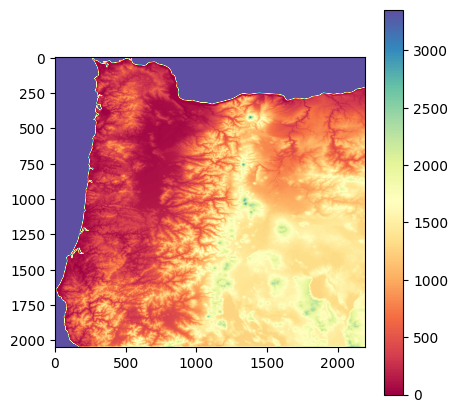

In [64]:
oregon_topography, value_range = clip_raster(oregon_poly, file)

plt.figure(figsize=(5,5))
c = plt.imshow(oregon_topography[0], cmap='Spectral')
plt.colorbar(c)
plt.show()

### Construct a colormap

Now we need to construct an appropriate **colourmap**. Here we make a five-class linear colormap using [ColorBrewer](https://colorbrewer2.org/) as inspiration. 

In [7]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

oregon_colormap = LinearSegmentedColormap.from_list('oregon', ['#edf8fb','#b2e2e2','#66c2a4','#2ca25f','#006d2c'],
                                                   N=value_range)

```{note}
All colors can be described using an **RGB triplet** or **hexadecimal** format (a hex triplet). In Python, hexadecimal color codes are defined with a leading number sign (`#`). More information can be found [here](https://en.wikipedia.org/wiki/Web_colors)
```

We still need to deal with the values that are not within Oregon. The solution is to construct a **colormap** with enough colours that each unique value within the Oregon elevation data has it's own colour, then replace the last colour in the colormap with our **background color**. 

In [8]:
from matplotlib.colors import ListedColormap

# Define an RGBA color
background_color = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])

newcolors = oregon_colormap(np.linspace(0, 1, value_range))
newcolors = np.vstack((newcolors, background_color))
oregon_colormap = ListedColormap(newcolors)

```{note}
This time we defined the background color using an **RGB triplet** + an alpha value which defines transparency.
```

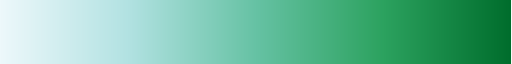

In [9]:
oregon_colormap

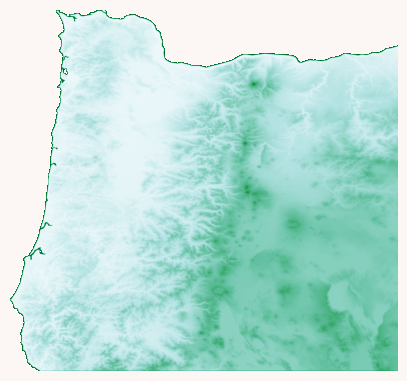

In [10]:
# Plot
fig = plt.figure(facecolor='#FCF6F5FF', figsize=(5,5))
ax = plt.axes()
plt.imshow(oregon_topography[0], cmap=oregon_colormap)
ax.axis('off')
plt.show()

### Adding a hillshade

The final step is to add a hillshade to mimic light shining on the topography. A hillshade is a 3D representation of a surface and are generally rendered in greyscale. The darker and lighter colors represent the shadows and highlights that you would visually expect to see in a terrain model.

We will use [`EarthPy`](https://earthpy.readthedocs.io/en/latest/index.html) to generate our hillshade data. There are two parameters that can be tuned and they give very different results depending on the dataset. The first is the **azimuth value** which can range from 0-360 degrees and relates to where the light source is shining from. 0 degrees corresponds to a light source pointing due north. The second is the altitude of the light source and can range from 1-90. Below are some examples demonstrating how changing the **azimuth value** produces vastly different results.

```{note}
`EarthPy` can be installed by running `pip install earthpy` from the terminal or command prompt.
```

(-0.5, 2191.5, 2043.5, -0.5)

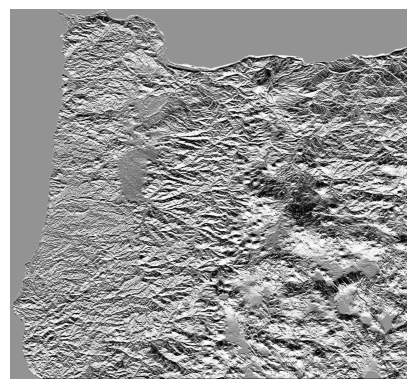

In [13]:
import earthpy.spatial as es

hillshade = es.hillshade(oregon_topography[0], 
                         azimuth=0, altitude=1)
plt.imshow(hillshade, cmap='Greys')
plt.axis('off')

(-0.5, 2191.5, 2043.5, -0.5)

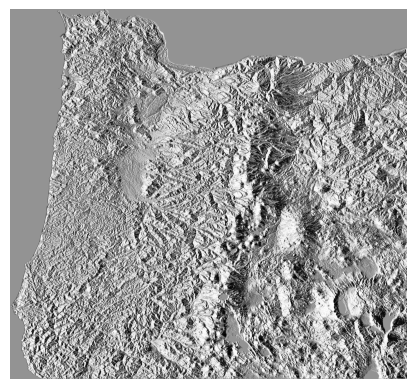

In [14]:
hillshade = es.hillshade(oregon_topography[0], 
                         azimuth=90, altitude=1)
plt.imshow(hillshade, cmap='Greys')
plt.axis('off')

(-0.5, 2191.5, 2043.5, -0.5)

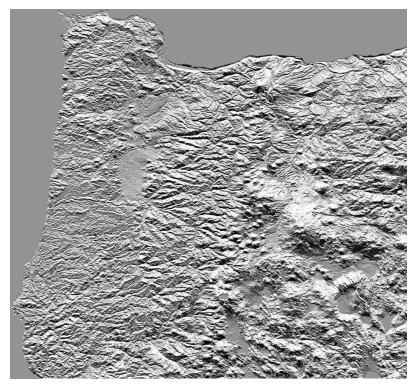

In [15]:
hillshade = es.hillshade(oregon_topography[0], 
                         azimuth=180, altitude=1)
plt.imshow(hillshade, cmap='Greys')
plt.axis('off')

(-0.5, 2191.5, 2043.5, -0.5)

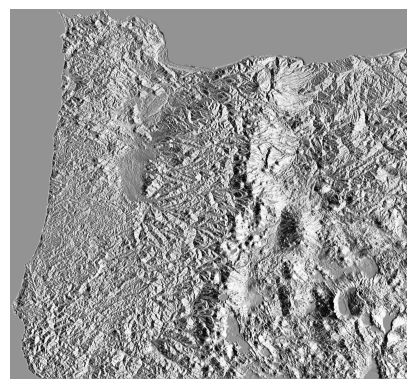

In [16]:
hillshade = es.hillshade(oregon_topography[0], 
                         azimuth=270, altitude=1)
plt.imshow(hillshade, cmap='Greys')
plt.axis('off')

An azimuth value of 90 produces a nice shadow on the eastern side of the Cascades and Crater Lake. Definitely play around with these values though because there may be even better hillshades.

### Plot map

We can now plot the finished product. To do is we first plot the Oregon topography, then overlay the hillshade with a small **alpha value** that sets transparency. 

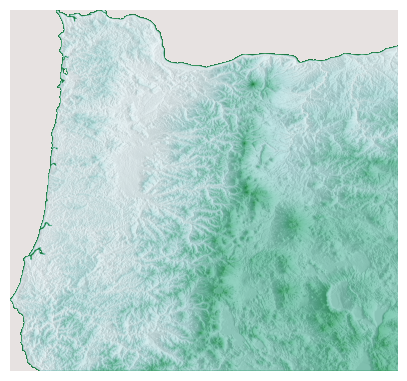

In [62]:
fig, ax = plt.subplots(figsize=(5,5))
im = plt.imshow(oregon_topography[0], 
                cmap=oregon_colormap)
ax.imshow(hillshade, cmap='Greys', alpha=0.2)
ax.axis('off')
plt.show()

### Add a colorbar and scalebar

If we were producing a figure for a journal article, we may also want to add a **colorbar** and a **scalebar**. A colorbar is fairly simple in `Matplotlib` but the default option is a little clumsy. The code below allows us to make the colorbar match the size of the plot.

Adding a scalebar in is a little more annoying because `Matplotlib` doesn't have any native functions to do this. But there is a package called [`matplotlib_scalebar`](https://github.com/ppinard/matplotlib-scalebar) that we can install which does the trick. 

We just have to find the size of each pixel in meters. We can use this [website](https://www.opendem.info/arc2meters.html) to convert 7.5 arc-seconds to meters at a specific latitude. 

```{note}
`matplotlib_scalebar` can be installed by running `pip install matplotlib-scalebar` from the terminal or command prompt.
```

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar

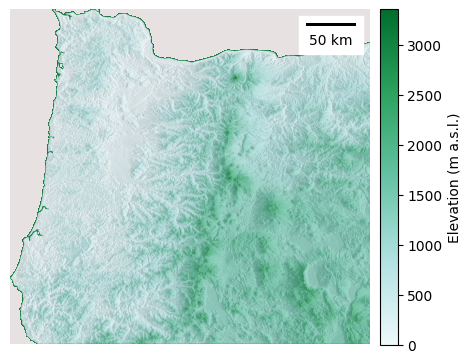

In [63]:
fig, ax = plt.subplots(figsize=(5,5))
im = plt.imshow(oregon_topography[0], cmap=oregon_colormap)
ax.imshow(hillshade, cmap='Greys', alpha=0.2)
ax.axis('off')

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.10)
fig.colorbar(im, cax=cax, orientation='vertical', 
             label='Elevation (m a.s.l.)')

#Scalebar
scalebar = ScaleBar(164,"m", length_fraction=0.2, pad=0.5, 
                    border_pad=0.5, location=1)
ax.add_artist(scalebar)
plt.show()

There we have it, a visually appealing topographic map of *most* of Orgeon ready to hang on a wall (or sell on Etsy...). 